In [1]:
from datetime import datetime
import pandas as pd
import seaborn as sns
import numpy as np
import json
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('DS Challenge.csv', sep=';', encoding='utf8')
df.head()

,ID_USER,genero,monto,fecha,hora,dispositivo,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude
0,0,F,"608,3456335",21/01/2020,20,{'model': 2020; 'device_score': 3; 'os': 'ANDR...,Super,Merida,FÃ­sica,71000,51,Aceptada,False,"60,83456335","5,475110702",False
1,0,F,"88,71924289",15/01/2020,7,{'model': 2020; 'device_score': 1; 'os': 'ANDR...,NaN,Merida,Virtual,71000,51,Aceptada,False,0,"1,774384858",False
2,1,F,"790,0376533",17/01/2020,11,"{'model': 2020; 'device_score': 1; 'os': ','}",NaN,Guadalajara,Virtual,94000,56,En proceso,False,0,"15,80075307",False
3,1,F,"767,0053873",5/01/2020,11,{'model': 2020; 'device_score': 3; 'os': 'WEB'},MPago,Guadalajara,FÃ­sica,94000,56,Aceptada,False,0,"7,670053873",False
4,1,F,"254,1710526",30/01/2020,10,{'model': 2020; 'device_score': 3; 'os': '%%'},NaN,Guadalajara,FÃ­sica,94000,56,Aceptada,False,0,"2,541710526",False


## EDA

Verificamos el tipo de variable de todos los parametros

In [3]:
df.dtypes

ID_USER             int64
genero             object
monto              object
fecha              object
hora                int64
dispositivo        object
establecimiento    object
ciudad             object
tipo_tc            object
linea_tc            int64
interes_tc          int64
status_txn         object
is_prime             bool
dcto               object
cashback           object
fraude               bool
dtype: object

* Se nota que los valores descuento, monto y cashback (devolucion) son string a pesar de ser obviamente númericos
* Se nota que la columna tipo_tc presenta un unicode character a ser cambiado
* Se tiene dos columnas para fecha: dia/mes/año y hora , por lo que se une en una sola columna
* Se tiene la columna genero con la cadena de caracteres '--' que representaría valor faltante, reemplazamos por nan

In [4]:
df['cashback'] = df['cashback'].str.replace(',', '.').astype(float)
df['monto'] = df['monto'].str.replace(',', '.').astype(float)
df['dcto'] = df['dcto'].str.replace(',', '.').astype(float)

# https://www.utf8-chartable.de/unicode-utf8-table.pl?start=128&number=128&utf8=string-literal&unicodeinhtml=hex
df['tipo_tc'] = df['tipo_tc'].str.replace('\xc3\xad','í').astype(str) 

df['date'] = df.apply(lambda row: datetime.strptime(str(row['fecha']) + ' ' + str(row['hora']) + ':00:00', '%d/%m/%Y %H:%M:%S').timestamp(), axis=1)
df['date'] = df['date'].astype('int64')

df['genero'] = df['genero'].replace('--', np.NaN)

* Se tiene un objecto dentro de la columna dispositivo que posee tres parametros más, por lo tanto creamos tres nuevas columnas para estos valores.

In [5]:
def split_dispositivo_column(row):
    dispositivo = row['dispositivo'].replace(';', ',').replace('\'','\"')
    model = json.loads(dispositivo).get('model')
    score = json.loads(dispositivo).get('device_score')
    os = json.loads(dispositivo).get('os')
    os = 'unknown_category_1' if os == ',' else ('unknown_category_2' if os == '%%' else os)
    return pd.Series([model, score, os])
    
df[['dispositivo_model', 'dispositivo_puntaje', 'dispositivo_os']] = df.apply(split_dispositivo_column, axis = 1)

In [6]:
df.head()

,ID_USER,genero,monto,fecha,hora,dispositivo,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,date,dispositivo_model,dispositivo_puntaje,dispositivo_os
0,0,F,608.345633,21/01/2020,20,{'model': 2020; 'device_score': 3; 'os': 'ANDR...,Super,Merida,Física,71000,51,Aceptada,False,60.834563,5.475111,False,1579654800,2020,3,ANDROID
1,0,F,88.719243,15/01/2020,7,{'model': 2020; 'device_score': 1; 'os': 'ANDR...,NaN,Merida,Virtual,71000,51,Aceptada,False,0.000000,1.774385,False,1579089600,2020,1,ANDROID
2,1,F,790.037653,17/01/2020,11,"{'model': 2020; 'device_score': 1; 'os': ','}",NaN,Guadalajara,Virtual,94000,56,En proceso,False,0.000000,15.800753,False,1579276800,2020,1,unknown_category_1
3,1,F,767.005387,5/01/2020,11,{'model': 2020; 'device_score': 3; 'os': 'WEB'},MPago,Guadalajara,Física,94000,56,Aceptada,False,0.000000,7.670054,False,1578240000,2020,3,WEB
4,1,F,254.171053,30/01/2020,10,{'model': 2020; 'device_score': 3; 'os': '%%'},NaN,Guadalajara,Física,94000,56,Aceptada,False,0.000000,2.541711,False,1580396400,2020,3,unknown_category_2


A continuación mostraremos los valores únicos de cada columna

In [9]:
for col in df.drop(['date', 'dispositivo'], axis=1):
    print(col + ': \t', df[col].unique())

ID_USER: 	 [   0    1    2 ... 3997 3998 3999]
genero: 	 ['F' nan 'M']
monto: 	 [608.3456335   88.71924289 790.0376533  ... 251.1898853   24.1826647
 517.2092724 ]
fecha: 	 ['21/01/2020' '15/01/2020' '17/01/2020' '5/01/2020' '30/01/2020'
 '27/01/2020' '6/01/2020' '11/01/2020' '19/01/2020' '8/01/2020'
 '18/01/2020' '7/01/2020' '26/01/2020' '4/01/2020' '25/01/2020'
 '22/01/2020' '16/01/2020' '12/01/2020' '29/01/2020' '14/01/2020'
 '28/01/2020' '3/01/2020' '10/01/2020' '2/01/2020' '13/01/2020'
 '20/01/2020' '9/01/2020' '23/01/2020' '24/01/2020']
hora: 	 [20  7 11 10  3  2 13 14  6 16 22  8 19 12 15 23 17 18 21  4  9  5  1]
establecimiento: 	 ['Super' nan 'MPago' 'Abarrotes' 'Farmacia' 'Restaurante']
ciudad: 	 ['Merida' 'Guadalajara' 'Toluca' 'Monterrey' nan]
tipo_tc: 	 ['Física' 'Virtual']
linea_tc: 	 [71000 94000 55000 62000 83000 33000 39000 72000 76000 44000 81000 64000
 34000 67000 87000 65000 28000 27000 99000 73000 63000 50000 46000 85000
 52000 38000 84000 37000 30000 61000 89000 8

Aqui cabe resaltar que existen valores númericos que representan categorias y no su valor perse, estos valores son:
* linea_tc
* interes_tc

A continuación mostramos estadisticos basicos del dataframe

In [10]:
df.describe()

,ID_USER,monto,hora,linea_tc,interes_tc,dcto,cashback,date,dispositivo_model,dispositivo_puntaje
count,26975.000000,26975.000000,26975.000000,26975.000000,26975.000000,26975.000000,26975.000000,2.697500e+04,26975.0,26975.000000
mean,2003.765412,499.069493,11.987618,62476.811863,48.224875,17.466134,6.261186,1.579198e+09,2020.0,3.002595
std,1144.630736,289.309518,6.642565,21886.892902,9.587256,34.334566,4.458440,7.244758e+05,0.0,1.417432
min,0.000000,0.017303,1.000000,25000.000000,32.000000,0.000000,0.000138,1.577945e+09,2020.0,1.000000
25%,1041.000000,246.521227,6.000000,44000.000000,40.000000,0.000000,2.791740,1.578568e+09,2020.0,2.000000
50%,2006.000000,500.501022,12.000000,62000.000000,48.000000,0.000000,5.636711,1.579198e+09,2020.0,3.000000
75%,2973.500000,749.598192,18.000000,82000.000000,57.000000,18.770710,8.531604,1.579828e+09,2020.0,4.000000
max,3999.000000,999.917764,23.000000,99000.000000,64.000000,199.356251,19.991582,1.580443e+09,2020.0,5.000000


* Existen 26975 filas en total.
* Existen 4000 usuarios a pesar de haber casi 27000 filas
* Monto: tiene un valor minimo de 0 y un valor máximo de 1000, lo interesante es como sus percentiles mantienen proporcion con los valores (25% ~ 250,  50% ~ 500 y 75% ~ 750)
* Hora: sabemos que existen 24 horas por lo que la divison entre 4 daria una sexta parte lo cual mantiene proporcion con los percentiles (25% de 24 es 6 y es just el percentil 25%, 50% de 24 es 12 y es justo el percentil 50, y asi para el 75%)
* El valor maximo de descuento es 200 y el minimo 0
* Cashback (devolucion): Las devoluciones tienen una media de 6 lo cual es bajo y un valor máximo de 19.99
* El modelo del dispositivo es un unico valor: 2020

Por la distribucion que se observa en el cuadro anterior no parece tener outliers en el monto pero de todas formas lo gráficaremos para estar seguros

### Boxplot - Monto

<AxesSubplot:xlabel='fraude', ylabel='monto'>

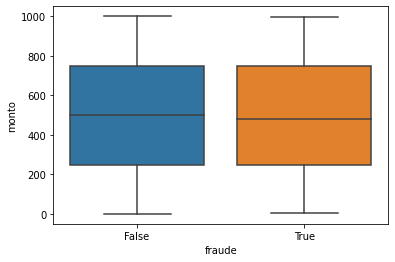

In [25]:
import seaborn as sns
sns.boxplot(x=df.fraude, y=df['monto'])

Sin embargo, para los casos de descuento (dcto) y devolucion (cashback) no necesariamente se aplica lo dicho para monto asi que observemos sus gráficas

### Boxplot - cashback

<AxesSubplot:xlabel='fraude', ylabel='cashback'>

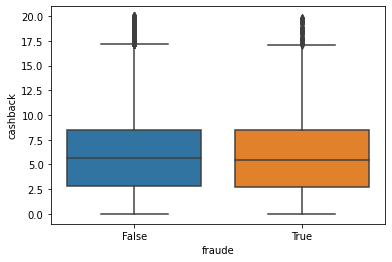

In [16]:
import seaborn as sns
sns.boxplot(x=df.fraude, y=df['cashback'])

### Boxplot - descuento

<AxesSubplot:xlabel='fraude', ylabel='dcto'>

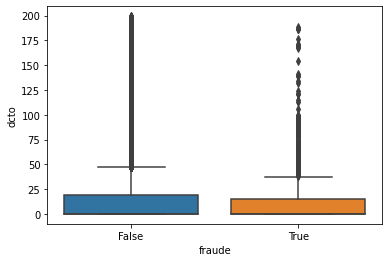

In [17]:
import seaborn as sns
sns.boxplot(x= df.fraude, y=df['dcto'])

Vemos que en ambos casos existen valores que no estan en la caja, eso a considerar más adelante en notebook Clasificacion

### Graficos de los párametros
#### Estado de la transacción

Text(0, 0.5, 'Cantidad')

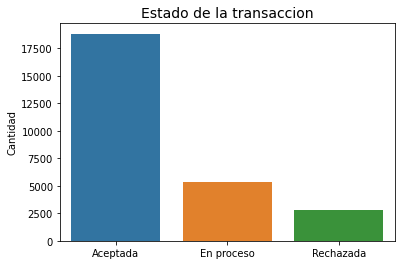

In [11]:
sns.countplot(x = 'status_txn', data=df)
plt.title('Estado de la transaccion', fontsize=14)
plt.xlabel('')
plt.ylabel('Cantidad')

Notamos que las transacciones de rechazadas son el grupo más pequeño en cantidad mientras que las aceptadas son el grupo con mayor cantidad

#### Prime

Text(0, 0.5, 'Cantidad')

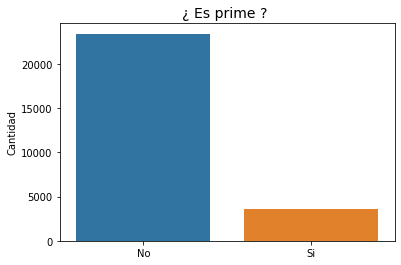

In [12]:
sns.countplot(x = 'is_prime', data=df)

ticks_locations, _ = plt.xticks();
labels = ['Si' if t else 'No' for t in ticks_locations]
plt.xticks(ticks_locations, labels)
plt.title('¿ Es prime ? ', fontsize=14)
plt.xlabel('')
plt.ylabel('Cantidad')

'Es prime', categoriza la transacción por lo que una transacción pudo ser 'prime' o 'no': en este caso aproximadamente 4000 transacciones aproximadamente fueron prime mientras que casi 24000 no lo fueron.

#### Tipo de transacción

Text(0, 0.5, 'Cantidad')

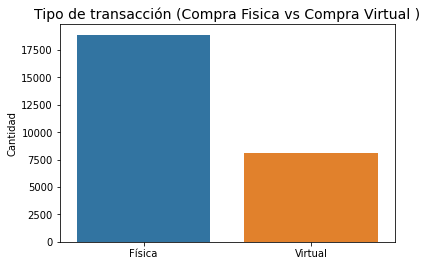

In [13]:
sns.countplot(x = 'tipo_tc', data=df)
plt.title('Tipo de transacción (Compra Fisica vs Compra Virtual )', fontsize=14)
plt.xlabel('')
plt.ylabel('Cantidad')

#### Ciudad donde se realizó la transacción

Text(0, 0.5, 'Cantidad')

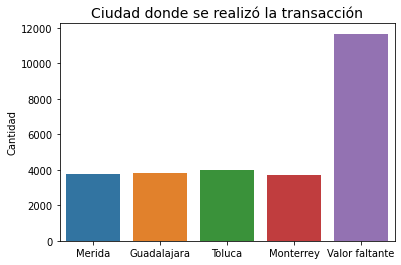

In [14]:
sns.countplot(x = 'ciudad', data=df.fillna('Valor faltante'))
plt.title('Ciudad donde se realizó la transacción', fontsize=14)
plt.xlabel('')
plt.ylabel('Cantidad')

Notamos que los valores faltantes superan ampliamente a las categorias conocidas, sin embargo en la sección 'Completando missing values' notaremos que estos valores faltantes pueden ser llenados con una estrategia ya que siguen un patron en el dataset

#### Género del comprado

Text(0, 0.5, 'Cantidad')

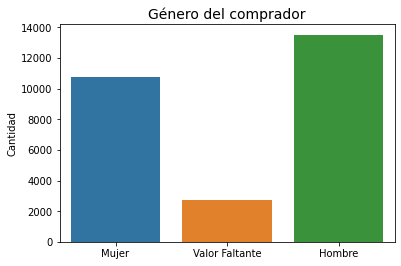

In [15]:
sns.countplot(x = 'genero', data=df.fillna('Valor Faltante'))

plt.xticks(np.arange(3), ("Mujer", "Valor Faltante","Hombre"))
plt.title('Género del comprador', fontsize=14)
plt.xlabel('')
plt.ylabel('Cantidad')

En la sección 'Completando missing values' notaremos que estos valores faltantes pueden ser llenados con una estrategia ya que siguen un patron en el dataset

#### Lugar donde se generó transacción

Text(0, 0.5, 'Cantidad')

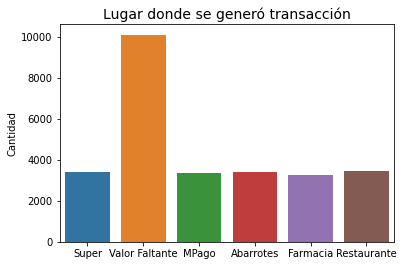

In [96]:
sns.countplot(x = 'establecimiento', data=df.fillna('Valor Faltante'))
plt.title('Lugar donde se generó transacción', fontsize=14)
plt.xlabel('')
plt.ylabel('Cantidad')

En la sección 'Completando missing values' notaremos que estos valores faltantes pueden ser llenados con una estrategia ya que siguen un patron en el dataset

#### Puntaje del dispositivo donde se generó la transacción 

Text(0, 0.5, 'Cantidad')

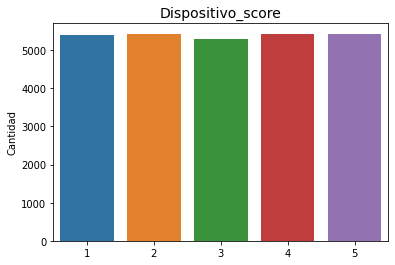

In [17]:
sns.countplot(x = 'dispositivo_puntaje', data=df)
plt.title('Dispositivo_score', fontsize=14)
plt.xlabel('')
plt.ylabel('Cantidad')

Esta columna ('dispositivo_score') esta proporcionada muy equitativamente

#### Sistema operativo del dispositivo que generó la transacción

Text(0, 0.5, 'Cantidad')

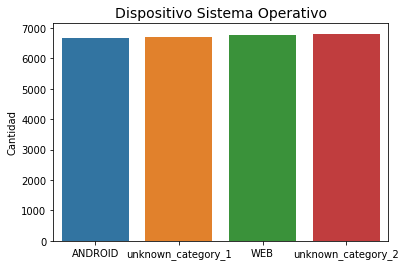

In [18]:
sns.countplot(x = 'dispositivo_os', data=df.replace(',', 'Categoria desconocida 1').replace('%%', 'Categoria desconocida 2'))
plt.title('Dispositivo Sistema Operativo', fontsize=14)
plt.xlabel('')
plt.ylabel('Cantidad')

A diferencia de un valor faltante el cual no tenemos ninguna información, aqui se tenia dos categorias
cuyos nombres eran ',' y '%%' los cuales tenian un porcentaje muy similar a sus valores conocidos 'ANDROID' y 'WEB'
por lo que se considero colocar dos nombres referenciales

### Linea_tc

Text(0, 0.5, 'Cantidad')

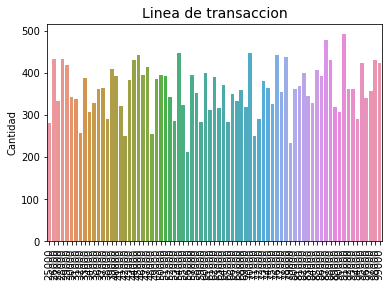

In [120]:
sns.countplot(x = 'linea_tc', data=df.fillna('Valor faltante'))
plt.title('Linea de transaccion', fontsize=14)
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Cantidad')

Observemos que este parámetro esta compuesto por varios valores los cuales entran en un rango de 300 y 500 hablando de frecuencia por lo que podemos inferir que sería una variable categórica

### Interes_Tc

Text(0, 0.5, 'Cantidad')

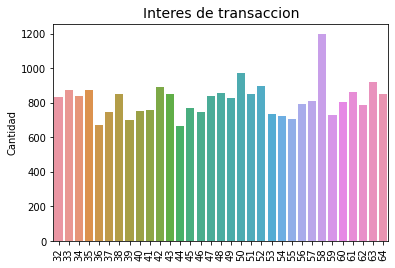

In [121]:
sns.countplot(x = 'interes_tc', data=df.fillna('Valor faltante'))
plt.title('Interes de transaccion', fontsize=14)
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Cantidad')

Lo mismo que la variable linea_tc, estos valores tienen una frecuencia 'armonica' se presentan entre 600 y 900 por categoria y tan solo uno llega aproximadamente a 1200 de frecuencia, por lo tanto inferimos que es una variable categorica representada por códigos

### Cantidad de valores faltantes por columna

Text(0.5, 1.0, 'Cantida de valores Faltantes en todas las columnas')

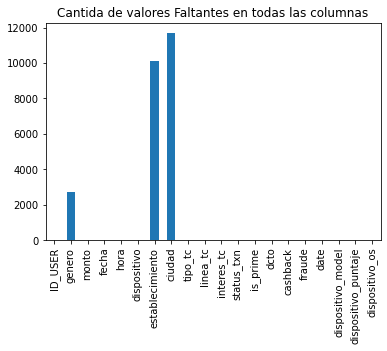

In [19]:
df.isnull().sum().plot.bar(x='lab', y='val', rot=90)
plt.title('Cantida de valores Faltantes en todas las columnas')

En este dataset consideraremos 3 datasets con valores faltantes género, establecimiento y ciudad, las demás columnas contienen todos sus datos conocidos (o en el caso de dispositivo_os: se estableció dos categorias sin nombre en vez de considerarlas faltantes)

### Valor de interés: ¿ Hubo Fraude o No ?
En estos problemas de fraude existen un problema conocido: el desbalance del dataset, ya que la cantidad de transacción que no es fraude supera enormemente la cantidad de transacción fraudulenta

Text(0, 0.5, 'Cantidad')

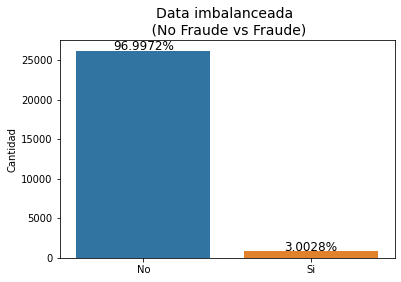

In [20]:
splot = sns.countplot(x = 'fraude', data=df)
total = len(df)
for p in splot.patches:
    splot.annotate(format(p.get_height()/total * 100, '.4f') + '%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center', 
                   size=12,
                   xytext = (0, 4), 
                   textcoords = 'offset points')
    
ticks_locations, _ = plt.xticks();
labels = ['Si' if t else 'No' for t in ticks_locations]
plt.xticks(ticks_locations, labels)
plt.title('Data imbalanceada \n (No Fraude vs Fraude)', fontsize=14)
plt.xlabel('')
plt.ylabel('Cantidad')

In [21]:
print('Fraude: {} %'.format(df['fraude'].value_counts()[0] / len(df) * 100))
print('No Fraude: {} %'.format(df['fraude'].value_counts()[1] / len(df) * 100))

Fraude: 96.99721964782205 %
No Fraude: 3.0027803521779424 %


Notamos entonces 97% aproxidamente de transacciones validas y 3% de transacciones fraudulentas

### Distribucciones de interés
#### Distribución por la cantidad (monto) de la transacción

C:\Users\Nilton\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

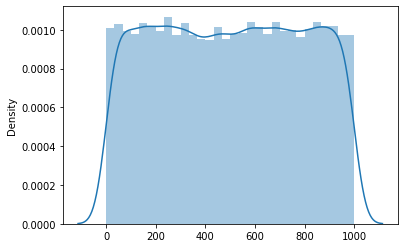

In [22]:
sns.distplot(x =  df['monto'].values)

Notamos que extrañamente se encuentra muy bien balanceada, es muy probable que esto se deba por fines del concurso, ya que data real extrañamente se encuentra datasets transaccionales con montos tan balanceados

#### Distribución por fecha de la transacción

C:\Users\Nilton\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


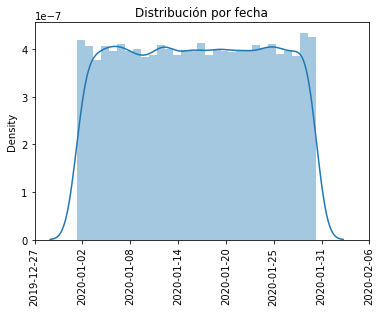

In [23]:
sns.distplot(x = df['date'].values)

ticks_locations, _ = plt.xticks();
labels = [datetime.fromtimestamp(int(t)).date() for t in ticks_locations]
plt.xticks(ticks_locations, labels, rotation=90)
plt.title("Distribución por fecha");

Notamos que se encuentra muy bien distribuido, también cabe destacar que estas transacciones ocurren en el mes de enero del 2020, por lo que ahora se sabé que:

Estos datos son transacciones de tarjeta de crédito los cuales contiene información escencial como donde se generó la transacción con que dispositivo a que hora, monto, descuento, devolución y si fue fraudulenta o no estos datos fueron recopilados por **UN mes (Enero del 2020) y de 4000 clientes**.

### Visualizaciones de interés

Veamos la media de todos los parámetros luego de agrupos por:

#### Género

In [106]:
df.drop(['ID_USER'], axis=1).groupby('genero').mean()

,monto,hora,linea_tc,interes_tc,is_prime,dcto,cashback,fraude,date,dispositivo_model,dispositivo_puntaje
genero,,,,,,,,,,,
F,500.274270,11.935577,61783.703151,47.977158,0.128659,17.295114,6.265238,0.031139,1.579202e+09,2020.0,2.990490
M,498.217103,11.967749,62881.278201,48.477698,0.138620,17.309950,6.266999,0.028700,1.579193e+09,2020.0,3.008507


Observamos:
 - Las mujeres en promedio consumen un poco más (2 puntos aproximadamente)
 - Las compras de hombres y mujeres se dan casi al medio dia (muy posiblmente por el dataset bastante equitativo en este parámetro)
 - El fraude se origino ligeramente más en el género F (Female o Mujer)
    

#### Establecimiento


In [107]:
df.drop(['ID_USER'], axis=1).groupby('establecimiento').mean()

,monto,hora,linea_tc,interes_tc,is_prime,dcto,cashback,fraude,date,dispositivo_model,dispositivo_puntaje
establecimiento,,,,,,,,,,,
Abarrotes,500.365394,11.962811,62359.882870,48.303367,0.125622,17.167221,6.159385,0.029868,1.579191e+09,2020.0,2.973646
Farmacia,498.515665,11.905305,62704.503393,48.204503,0.127082,17.864013,6.236934,0.028378,1.579210e+09,2020.0,3.006786
MPago,501.332814,12.097816,61935.088244,48.130123,0.142686,16.791104,6.253694,0.031110,1.579222e+09,2020.0,3.022435
Restaurante,497.760850,11.953677,62583.960625,48.150550,0.138680,17.643108,6.279409,0.026925,1.579193e+09,2020.0,2.981181
Super,490.855773,12.019106,61816.578483,48.081129,0.128160,17.711514,6.159535,0.029982,1.579198e+09,2020.0,3.035861


Observamos:
  - El monto es muy similar en todos los tiplos de establecimiento.
  - El Fraude se da ligeramente más por MPago (mercado pago)
  - Asi mismo existe menos descuento en MPago
  - La devolución (cashback) es muy similar en todos los tipos de establecimiento
  

#### Ciudad

In [108]:
df.drop(['ID_USER'], axis=1).groupby('ciudad').mean()

,monto,hora,linea_tc,interes_tc,is_prime,dcto,cashback,fraude,date,dispositivo_model,dispositivo_puntaje
ciudad,,,,,,,,,,,
Guadalajara,495.541946,12.041743,61391.860162,48.543699,0.148969,17.813352,6.180063,0.030785,1.579198e+09,2020.0,3.017480
Merida,501.375245,12.115927,63547.992555,48.117256,0.135070,17.964757,6.291961,0.031906,1.579185e+09,2020.0,3.042010
Monterrey,496.426942,11.926606,61177.549919,48.850513,0.126552,18.649250,6.241854,0.026983,1.579199e+09,2020.0,3.022666
Toluca,501.578424,11.856642,63456.592444,47.812109,0.132099,17.269010,6.262216,0.029522,1.579209e+09,2020.0,2.984739


Observamos:
  - Podemos decir que ligeramente es más el fraude en Guadalajara y Mérida
  - Existe un poco más de descuento en Monterrey
  - Monto, hora y cashback se mantienen igual que en las observaciones anteriores con valores muy equitativos

#### Sistema operativo de dispositivos

In [109]:
df.drop(['ID_USER'], axis=1).groupby('dispositivo_os').mean()

,monto,hora,linea_tc,interes_tc,is_prime,dcto,cashback,fraude,date,dispositivo_model,dispositivo_puntaje
dispositivo_os,,,,,,,,,,,
ANDROID,493.998728,11.902034,62163.924619,48.242447,0.130571,17.705351,6.178529,0.032306,1.579196e+09,2020.0,3.011068
WEB,500.652409,11.860479,62374.815253,48.249926,0.133166,17.047568,6.281364,0.027934,1.579201e+09,2020.0,2.996157
unknown_category_1,502.383122,12.147431,62638.719285,48.302904,0.136113,17.805684,6.319015,0.028593,1.579209e+09,2020.0,2.999255
unknown_category_2,499.207875,12.040394,62725.763807,48.105758,0.127938,17.312277,6.265267,0.031287,1.579185e+09,2020.0,3.003966


Observamos:
  - ligeramente se da mayor fraude en Android y en la categoria desconocida 2

### Podemos ver los códigos más repetitivo (linea_tc y interes_tc) por tipo de transaccion

In [124]:
df.drop(['ID_USER'], axis=1).groupby('tipo_tc').agg({'linea_tc': lambda x: x.mode(), 'interes_tc': lambda x: x.mode()})

,linea_tc,interes_tc
tipo_tc,,
Física,87000,58
Virtual,91000,58


Observamos que:
  - En las transacciones físicas tenemos de uso más frecuente la linea 87000 y el interes 58.
  - En las transacciones virtuales tenemos de uso más frecuente la linea 9100 y el interes 58 también.

### Frecuencias por fraude

#### Tipo de transaccion

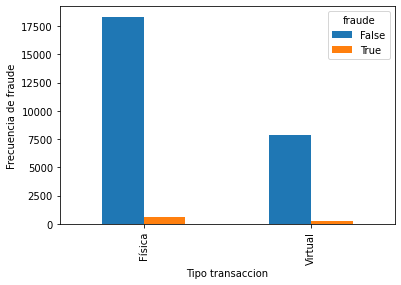

In [125]:
%matplotlib inline
pd.crosstab(df.tipo_tc,df.fraude).plot(kind='bar')
plt.xlabel('Tipo transaccion')
plt.ylabel('Frecuencia de fraude')
plt.show()

Aqui podemos observar como el fraude se da ligeramente más en las transacciones fisicas que en las virtuales (True = Si fraude)

#### Establecimiento

Text(0, 0.5, 'Proporcion fraude - no fraude')

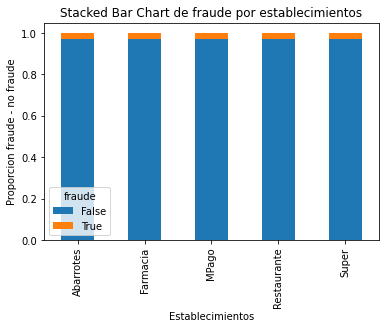

In [131]:
table=pd.crosstab(df.establecimiento,df.fraude)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart de fraude por establecimientos')
plt.xlabel('Establecimientos')
plt.ylabel('Proporcion fraude - no fraude')

Sorprendentemente el fraude en cada establecimiento es el mismo o bastante similar para cada uno de estos (posiblemente por el challengue esto fue extraido asi), esto tambien se ve por ciudades como veremos a continuación...

Text(0.5, 0, 'Establecimientos')

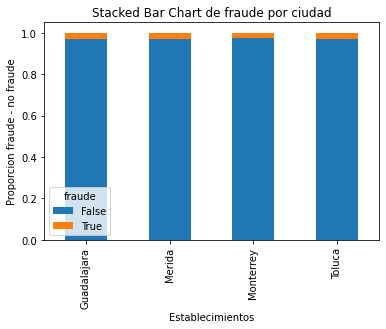

In [129]:
table=pd.crosstab(df.ciudad,df.fraude)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart de fraude por ciudad')
plt.ylabel('Proporcion fraude - no fraude')
plt.xlabel('Establecimientos')

####  Completando missing values en siguiente notebook (Clasificacion.ipynb)